# 3.1 MLP 구축과 학습
#### 활성화 함수가 필요한 이유
- 단순히 선형계층을 연결만 하면 결과적으로 전체가 선형 함수가 되어버리므로 각 층의 출력에 활성화함수라는 비선형 함수를 적용한다.
- ReLU: 딥러닝 이전에는 시그모이드, tanh 등이 많이 쓰였었지만 기울기 소실 문제로 인해 ReLU가 폭넓게 쓰이는 중이다.   

In [1]:
import torch
from torch import nn

# 층이 일직선으로 쌓인 형태의 피드포워드 형태의 신경망
# 64차원을 입력으로 받아 10차원을 뱉음
net = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,10)
)

- 피드포워드형 신경망의 미분을 구할 때는 역전파를 사용한다.

In [2]:
from torch import optim
from sklearn.datasets import load_digits
digits = load_digits()

x = digits.data
y = digits.target

# 넘파이배열을 tensor로 변환
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

x = x.to('cuda:0')
y = y.to('cuda:0')
net.to('cuda:0')

# 소프트맥스 크로스 엔트로피로 로스함수 설정
loss_fn = nn.CrossEntropyLoss()

# Adam optimizer 설정
optimizer = optim.Adam(net.parameters())

# 손실 함수 로그(기록)
losses = []

# 100회 반복
for epoch in range(100):
    optimizer.zero_grad()
    
    y_pred = net(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    
    optimizer.step()
    
    losses.append(loss.item())

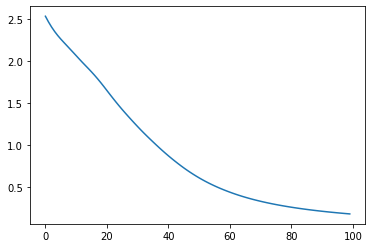

In [3]:
import matplotlib.pyplot as plt
plt.plot(losses)

# 3.2 Dataset과 DataLoader

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

In [11]:
# Dataset 작성
ds = TensorDataset(x,y)

# 순서로 섞어서 64개씩 데이터를 반환하는 DataLoader 작성
loader = DataLoader(ds, batch_size=64, shuffle=True)

net = nn.Sequential(
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,16),
    nn.ReLU(),
    nn.Linear(16,10)
)
net.to('cuda:0')
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# 최적화 실행
losses = []
running_losses = []
for epoch in range(10):
    running_loss = 0.0
    for xx, yy in loader:
        # xx, yy 64개만 받는다.
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_losses.append(running_loss)
    losses.append(running_loss)

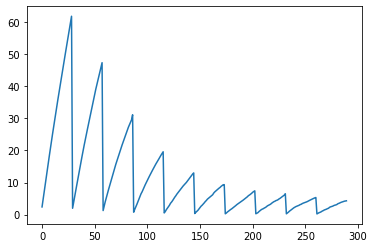

In [14]:
plt.plot(running_losses)

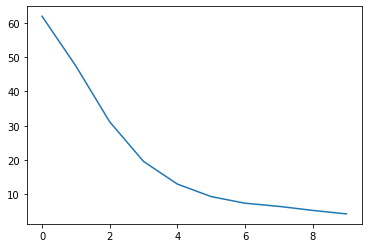

In [13]:
plt.plot(losses)

# 3.3 학습 효율화 팁(dropout, batch normalization)


### 다음의 순서는 상관 없음
- x,y -> 스플릿 -> tensor화
- x,y -> tensor화 -> 스플릿

## mini batch
- SGD의 반복이 늘어나면 validation의 loss가 상승함

In [34]:
%%time
import torch
from torch import nn, optim
# 데이터를 훈려용과 검증용으로 분할
from sklearn.model_selection import train_test_split
# 전체의 30%는 검증용
X = digits.data
y = digits.target

# 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)


# # train, test 스플릿을 텐서변환 후에 해도 된다
# X = torch.tensor(X, dtype = torch.float32)
# y = torch.tensor(y, dtype = torch.int64)


k = 100
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, 10),
    nn.ReLU(),
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
# 훈련용 데이터로 DataLoader를 작성

ds = TensorDataset(X_train, y_train)
loader = DataLoader(ds, batch_size=32, shuffle=True)

Wall time: 2 ms


In [35]:
%%time
train_losses = []
test_losses = []
for epoch in range(100):
    running_loss = 0.0
    # mini batch
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)            # 미니 배치 넣어서 예측 
        loss = loss_fn(y_pred, yy)   # loss 계산
        optimizer.zero_grad()       # 경사 초기화
        loss.backward()             # 미분 계산
        optimizer.step()            # 기울기 갱신
        running_loss += loss.item() # 에폭에서의 loss
    train_losses.append(running_loss / i) # 매 batch_size에서의 평균적인 loss 계산
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, y_test)
    test_losses.append(test_loss.item())

Wall time: 9.02 s


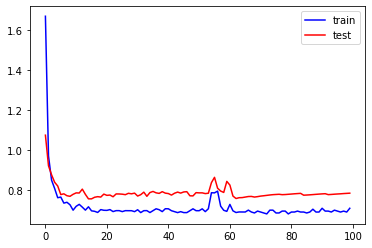

In [40]:
plt.plot(train_losses, c='b',label='train')
plt.plot(test_losses, c = 'r',label='test')
plt.legend()

## 정규화
- 과학습을 방지하는 것

## 3.3.1 Dropout을 사용한 학습 가속

In [42]:
# 확률 0.5로 랜덤으로 변수의 차원을 버려버림
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(k, 10)
)

In [44]:
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []

for epoch in range(100):
    running_loss = 0.0
    # 훈련모드 on!
    net.train()
    for i, (xx,yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    # 평가모드 on!
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, y_test)
    test_losses.append(test_loss.item())

## Batch Normalization을 이용한 학습 가속
- 한 에폭을 한번에 넣어주면 좋지만 mini-batch를 이용하기 때문에 매 mini-batch마다 BN을 수행한다.
- 미니 배치에 대한 정규화를 수행하는 것
- covariate shift를 줄여줌

In [48]:
net = nn.Sequential(
    nn.Linear(64,k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    
    nn.Linear(k, 10)
)

# 3.4 신경망의 모듈화
## 3.4.1 자체 신경망 계층(커스텀 계층) 만들기
- forward 메서드를 구현하면 자동 미분까지 가능

In [51]:
# 커스텀 선형 계층을 만들어보자
class CustomLinear(nn.Module):
    def __init__(self, in_features,
                out_features,
                bias=True, p=0.5):
        super().__init__()  # "속성"을 상속받음
        self.linear = nn.Linear(in_features,
                               out_features,
                               bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
    
    def forward(self,x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.drop(x)
        return x


#### Sequential 사용
mlp = nn.Sequential(
    CustomLinear(64,200),
    CustomLinear(200,200),
    CustomLinear(200,200),
    nn.Linear(200,10)
)

In [52]:
class MyMLP(nn.Module):
    def __init__(self, in_features,
                out_features):
        super().__init__()
        self.ln1 = CustomLinear(in_features, 200)
        self.ln2 = CustomLinear(200, 200)
        self.ln3 = CustomLinear(200, 200)
        self.ln4 = CustomLinear(200, out_features)
        
    def forward(self, x):
        x = self.ln1(x)
        x = self.ln2(x)
        x = self.ln3(x)
        x = self.ln4(x)
        return x
    
mlp = MyMLP(64,10)

# 3장 정리
- MLP도 선형 모델처럼 경사하강법을 사용하여 학습할 수 있고, 이때 미분 계산을 자동 미분을 통해 쉽게 할 수 있다.
- TensorDataset: x,y를 통해 pytorch를 위한 데이터셋 준비


예)  ds = TensorDataset(x,y)


- DataLoader: 순서로 섞어서 batch_size(=64) 만큼의 데이터를 반환해주는 로더

예)  loader = DataLoader(ds, batch_size=64, shuffle=True)